In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

Mounted at /content/gdrive/


In [ ]:
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

In [ ]:
import sys
import keras
import cv2
import numpy
import matplotlib
import skimage

print('Python: {}'.format(sys.version))
print('Keras: {}'.format(keras.__version__))
print('OpenCV: {}'.format(cv2.__version__))
print('NumPy: {}'.format(numpy.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('Scikit-Image: {}'.format(skimage.__version__))

Python: 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
Keras: 2.12.0
OpenCV: 4.7.0
NumPy: 1.22.4
Matplotlib: 3.7.1
Scikit-Image: 0.19.3


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from skimage.metrics import structural_similarity as ssim
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math
import os
import sys

%matplotlib inline

In [ ]:
def psnr(target, ref):

    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')
    rmse = math.sqrt(np.mean(diff ** 2.))
    return 20 * math.log10(255. / rmse)

# define function for mean squared error (MSE)
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])

    return err

# define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel =True))

    return scores

In [ ]:
# prepare degraded images by introducing quality distortions via resizing

def prepare_images(file, factor):
      # open the file
      img = cv2.imread(file)

      # find old and new image dimensions
      h, w, _ = img.shape
      new_height = h / factor
      new_width = w / factor

      # resize the image - down
      img = cv2.resize(img, (int(new_width), int(new_height)), interpolation = cv2.INTER_LINEAR)

      # resize the image - up
      img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)

      # save the image
      print('Saving {}'.format(file))
      cv2.imwrite('{}'.format(file), img)

In [ ]:
prepare_images('/content/gdrive/MyDrive/Soft_Computing/degrade/bird_GT.bmp',2)

Saving /content/gdrive/MyDrive/Soft_Computing/degrade/bird_GT.bmp


In [ ]:

target = cv2.imread('/content/gdrive/MyDrive/Soft_Computing/degrade/bird_GT.bmp')
ref = cv2.imread('/content/gdrive/MyDrive/Soft_Computing/source/bird_GT.bmp')

# calculate score
scores = compare_images(target, ref)

# print all three scores with new line characters (\n)
print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(ref, scores[0], scores[1], scores[2]))

[[[ 18  40  19]
  [ 17  39  19]
  [ 15  35  15]
  ...
  [ 76 135 107]
  [104 149 124]
  [131 163 139]]

 [[ 16  38  19]
  [ 15  37  18]
  [ 12  32  13]
  ...
  [122 159 132]
  [147 172 146]
  [165 182 157]]

 [[ 13  35  16]
  [ 12  34  15]
  [ 10  30  11]
  ...
  [154 171 146]
  [152 173 148]
  [140 168 142]]

 ...

 [[118 167 156]
  [ 41  93  88]
  [ 68 124 123]
  ...
  [ 27  87  27]
  [ 29  88  34]
  [ 31  88  39]]

 [[128 177 166]
  [ 49 101  96]
  [ 55 111 110]
  ...
  [ 25  87  27]
  [ 26  89  34]
  [ 27  88  39]]

 [[134 183 172]
  [ 59 111 106]
  [ 46 102 101]
  ...
  [ 23  87  27]
  [ 22  90  34]
  [ 24  89  39]]]
PSNR: 25.351830827215956
MSE: 568.8772063078703
SSIM: 0.7737291789194362



<ipython-input-5-86a5c43c0f29>:25: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  scores.append(ssim(target, ref, multichannel =True))


In [ ]:
def model():

    # define model type
    SRCNN = Sequential()

    # add model layers
    SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))

    # define optimizer
    adam = Adam(learning_rate=0.0003)

    # compile model
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])

    return SRCNN

In [ ]:
def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1:sz[1]]
    return img


def shave(image, border):
    img = image[border: -border, border: -border]
    return img

In [ ]:
def predict(image_path):
    weight_path='/content/gdrive/MyDrive/3051crop_weight_200.h5'
    # load the srcnn model with weights
    srcnn = model()
    srcnn.load_weights(weight_path)

    # load the degraded and reference images
    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread('/content/gdrive/MyDrive/Soft_Computing/source/bird_GT.bmp')

    # preprocess the image with modcrop
    ref = modcrop(ref, 3)
    degraded = modcrop(degraded, 3)

    # convert the image to YCrCb - (srcnn trained on Y channel)
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)

    # create image slice and normalize
    Y = numpy.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255

    # perform super-resolution with srcnn
    pre = srcnn.predict(Y, batch_size=1)

    # post-process output
    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)

    # copy Y channel back to image and convert to BGR
    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)

    # remove border from reference and degraged image
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)

    # image quality calculations
    scores = []
    scores.append(compare_images(degraded, ref))
    scores.append(compare_images(output, ref))

    # return images and scores
    return ref, degraded, output, scores

1/1 [==============================] - 8s 8s/step
Degraded Image: 
PSNR: 25.383548087966233
MSE: 564.7377338603426
SSIM: 0.7750899445350492

Reconstructed Image: 
PSNR: 25.807366051940978
MSE: 512.23
SSIM: 0.7907244787368732



<ipython-input-5-86a5c43c0f29>:25: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  scores.append(ssim(target, ref, multichannel =True))


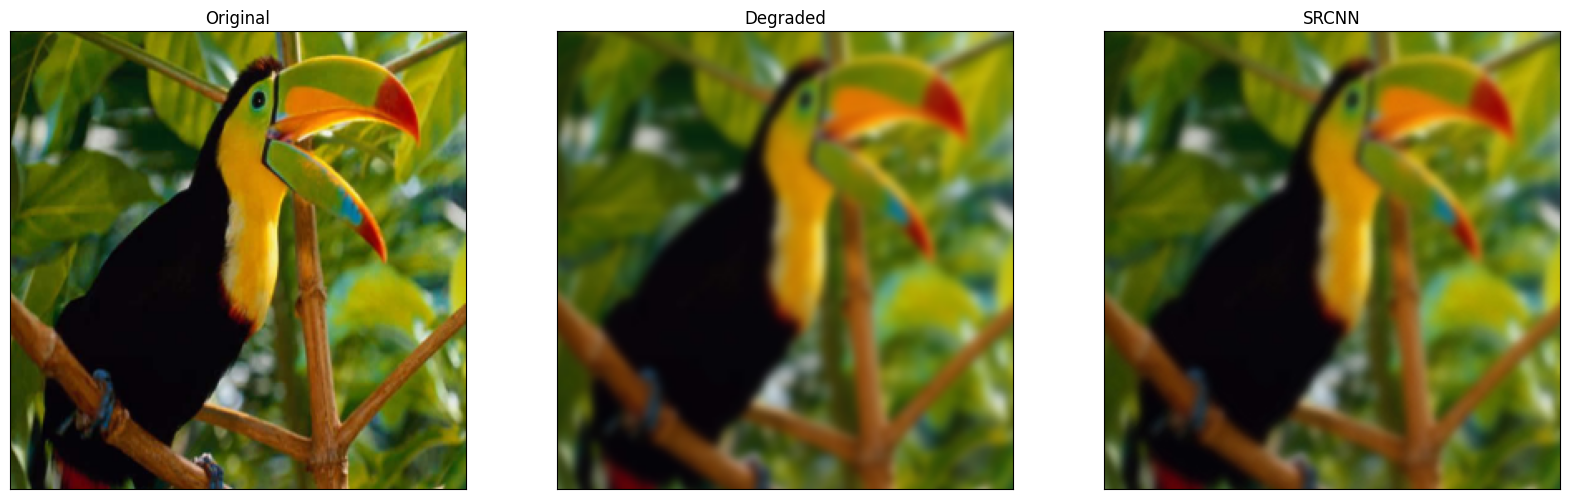

In [ ]:
image_path='/content/gdrive/MyDrive/Soft_Computing/degrade/bird_GT.bmp'
ref, degraded, output, scores = predict(image_path)

# print all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])